In [1]:

import quimb as qu
import quimb.tensor as qtn

In [2]:
# contengra is a library for optimizing tensor network contractions
# tensor network contractions are done by repeatedly contracting pairs of tensors
import cotengra as ctg
# ReusableHyperOptimizer is a subclass of HyperOptimizer which is used to optimize a single
#  path repeatedly. This is useful for optimizing paths which are reused many times, such as in a DMRG sweep.
# the arguments are as follows: methods, reconf_opts, max_repeats, max_time, parallel, directory
# methods: list of methods to use for optimization
# reconf_opts: dictionary of options to pass to the reconfigurer
# max_repeats: maximum number of times to repeat the optimization
# max_time: maximum time to spend optimizing
# parallel: whether to use parallel optimization
# directory: whether to use a directory to cache paths
opt = ctg.ReusableHyperOptimizer(
    methods=['greedy'],
    reconf_opts={}, 
    max_repeats=32,
    max_time="rate:1e6",
    parallel=True,
    # use the following for persistently cached paths
    # directory=True,
)

c:\Users\sruhti patil\AppData\Local\Programs\Python\Python38\lib\site-packages\cotengra\hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


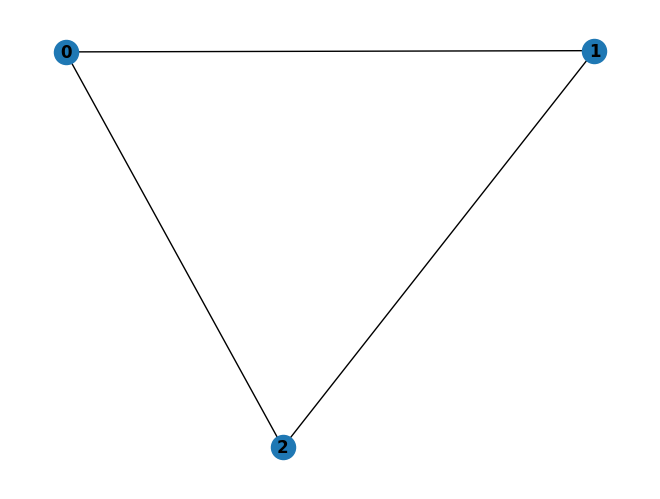

In [3]:
import networkx as nx
# create a 4 regular graph with 5 nodes

n = 3
seed = 666
edges = {(0, 1):48, (0, 2):91, (1, 2): 63}
G = nx.Graph()
G.add_nodes_from(range(n))
G.add_edges_from(edges.keys())
# add weights to the edges
nx.set_edge_attributes(G, edges, 'weight')
nx.draw(G, with_labels=True, font_weight='bold')
terms = {(0, 1):48, (0, 2):91, (1, 2): 63}

In [10]:
edges = []
for j in range(9):
    for i in range(9):
        if i < j:
            edges.append((i,j))
print(edges)

weights = [606.5,606.5,606.5,606.5,15.75,15.75,15.75,606.5,15.75,606.5,15.75,15.75,606.5,606.5,606.5,606.5,22.75,22.75,606.5,12,12,22.75,606.5,22.75,12,606.5,12,606.5,22.75,22.75,606.5,12,12,606.5,606.5,606.5]

graph = dict(zip(edges,weights))
print(graph)

[(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3), (0, 4), (1, 4), (2, 4), (3, 4), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8)]
{(0, 1): 606.5, (0, 2): 606.5, (1, 2): 606.5, (0, 3): 606.5, (1, 3): 15.75, (2, 3): 15.75, (0, 4): 15.75, (1, 4): 606.5, (2, 4): 15.75, (3, 4): 606.5, (0, 5): 15.75, (1, 5): 15.75, (2, 5): 606.5, (3, 5): 606.5, (4, 5): 606.5, (0, 6): 606.5, (1, 6): 22.75, (2, 6): 22.75, (3, 6): 606.5, (4, 6): 12, (5, 6): 12, (0, 7): 22.75, (1, 7): 606.5, (2, 7): 22.75, (3, 7): 12, (4, 7): 606.5, (5, 7): 12, (6, 7): 606.5, (0, 8): 22.75, (1, 8): 22.75, (2, 8): 606.5, (3, 8): 12, (4, 8): 12, (5, 8): 606.5, (6, 8): 606.5, (7, 8): 606.5}


In [4]:
lattice_cite = [i for i in range(9)]
field_str = [-1290,-1290,-1290,-1268.5,-1268.5,-1268.5,-1282.5,-1282.5,-1282.5]
diag_terms = dict(zip(lattice_cite,field_str))

In [34]:
def circuit_qaoa(
    terms,
    diagonal_terms,
    depth,
    gammas,
    betas,
    **circuit_opts,
):
    r"""Generate the QAOA circuit for weighted graph described by ``terms``.

    .. math::

        |{\bar{\gamma}, \bar{\beta}}\rangle = U_B (\beta _p)
        U_C (\gamma _p) \cdots U_B (\beta _1) U_C (\gamma _1) |{+}\rangle

    with

    .. math::

        U_C (\gamma) = e^{-i \gamma \mathcal{C}} = \prod \limits_{i, j
        \in E(G)} e^{-i \gamma w_{i j} Z_i Z_j}

    and

    .. math::

        U_B (\beta) = \prod \limits_{i \in G} e^{-i \beta X_i}


    Parameters
    ----------
    terms : dict[tuple[int], float]
        The mapping of integer pair keys ``(i, j)`` to the edge weight values,
        ``wij``. The integers should be a contiguous range enumerated from
        zero, with the total number of qubits being inferred from this.
    diagonal_terms: dict[tuple[int], float]
        the mapping of diagonal terrms (i,i) to the weight values or external field values 
    depth : int
        The number of layers of gates to apply, ``p`` above.
    gammas : iterable of float
        The interaction angles for each layer.
    betas : iterable of float
        The rotation angles for each layer.
    circuit_opts
        Supplied to :class:`~quimb.tensor.circuit.Circuit`. Note
        ``gate_opts={'contract': False}`` is set by default (it can be
        overridden) since the RZZ gate, even though it has a rank-2
        decomposition, is also diagonal.
    """
    #from .circuit import Circuit


    circuit_opts.setdefault('gate_opts', {})
    circuit_opts['gate_opts'].setdefault('contract', False)


    n = 9
    #max(itertools.chain.from_iterable(terms)) + 1


    gates = []


    # layer of hadamards to get into plus state
    for i in range(n):
        gates.append((0, 'h', i))


    for d in range(depth):
        for (i, j), wij in terms.items():
            gates.append((d, 'rzz', wij * gammas[d], i, j))
        
        for i, h_i in diagonal_terms.items():
            gates.append((d, 'rz',h_i* gammas[d],i))


        for i in range(n):
            gates.append((d, 'rx', -betas[d] * 2, i))


    circ = qtn.Circuit(n, **circuit_opts)
    circ.apply_gates(gates)


    return circ

In [35]:
p = 4
gammas = qu.randn(p)
betas = qu.randn(p)
circ_ex = circuit_qaoa(graph, diag_terms, p, gammas, betas)

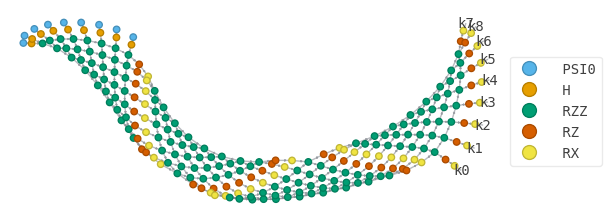

In [36]:
circ_ex.psi.draw(color=['PSI0', 'H', 'RZZ','RZ', 'RX'],show_inds=True)


In [38]:
diag_terms.items()

dict_items([(0, -1290), (1, -1290), (2, -1290), (3, -1268.5), (4, -1268.5), (5, -1268.5), (6, -1282.5), (7, -1282.5), (8, -1282.5)])

In [39]:
graph.items()

dict_items([((0, 1), 606.5), ((0, 2), 606.5), ((1, 2), 606.5), ((0, 3), 606.5), ((1, 3), 15.75), ((2, 3), 15.75), ((0, 4), 15.75), ((1, 4), 606.5), ((2, 4), 15.75), ((3, 4), 606.5), ((0, 5), 15.75), ((1, 5), 15.75), ((2, 5), 606.5), ((3, 5), 606.5), ((4, 5), 606.5), ((0, 6), 606.5), ((1, 6), 22.75), ((2, 6), 22.75), ((3, 6), 606.5), ((4, 6), 12), ((5, 6), 12), ((0, 7), 22.75), ((1, 7), 606.5), ((2, 7), 22.75), ((3, 7), 12), ((4, 7), 606.5), ((5, 7), 12), ((6, 7), 606.5), ((0, 8), 22.75), ((1, 8), 22.75), ((2, 8), 606.5), ((3, 8), 12), ((4, 8), 12), ((5, 8), 606.5), ((6, 8), 606.5), ((7, 8), 606.5)])

In [40]:
def energy(x):
    p = len(x) // 2
    gammas = x[:p]
    betas = x[p:]
    circ = circuit_qaoa(graph,diag_terms, p, gammas, betas)

    ZZ = qu.pauli('Z') & qu.pauli('Z')
    Z = qu.pauli('Z')
    ens = [
        circ.local_expectation(weight * ZZ, edge, optimize=opt)
        for edge, weight in graph.items()
    ]
    ens_diag = [circ.local_expectation(weight * Z, cite, optimize=opt)
        for cite, weight in diag_terms.items()
    ]
    return sum(ens).real + sum(ens_diag).real

In [41]:
import tqdm
# qu.pauli returns a tensor representing the pauli matrix corresponding to the argument
# here we are using it to get the tensor representation of the pauli Z matrix
# ZZ is the tensor product of two Z matrices; 
ZZ = qu.pauli('Z') & qu.pauli('Z')
# local_expectation_rehearse returns the expectation value of the local operator
#local operator is the operator which acts on a single qubit
# the arguments are the local operator, the edge on which the local operator acts, and the optimization method
# expectation value of the operator is the sum of the product of the operator and the state over all possible states
# physically it meanse the average value of the operator 
local_exp_rehs = [
    circ_ex.local_expectation_rehearse(weight * ZZ, edge, optimize=opt)
    for edge, weight in tqdm.tqdm(list(graph.items()))
]

  0%|          | 0/36 [00:00<?, ?it/s]c:\Users\sruhti patil\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 36/36 [17:01<00:00, 28.38s/it]  


In [43]:
Z = qu.pauli('Z') 

local_exp_rehs_diag = [
    circ_ex.local_expectation_rehearse(weight * Z, cite, optimize=opt)
    for cite, weight in tqdm.tqdm(list(diag_terms.items()))
]

100%|██████████| 9/9 [06:03<00:00, 40.40s/it]


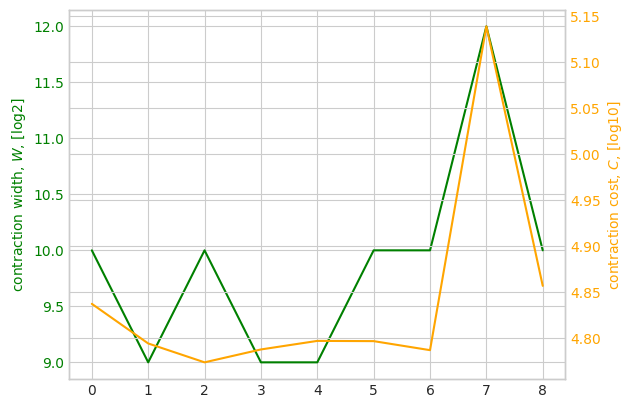

In [44]:

# contraction 
with plt.style.context(plt.style.available[26]):
    fig, ax1 = plt.subplots() # instantiate a figure and an axes
    ax1.plot([rehs['W'] for rehs in local_exp_rehs_diag], color='green') # contraction width is the number of tensors in the contraction path
    ax1.set_ylabel('contraction width, $W$, [log2]', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
    ax2.plot([rehs['C'] for rehs in local_exp_rehs_diag], color='orange') # contraction cost is the number of floating point operations in the contraction path
    ax2.set_ylabel('contraction cost, $C$, [log10]', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

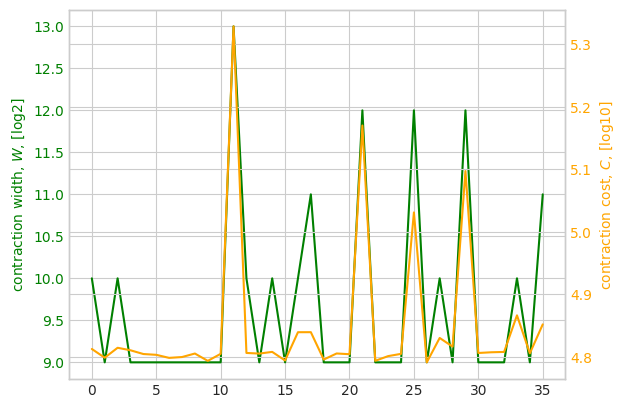

In [42]:
import matplotlib.pyplot as plt
# contraction 
with plt.style.context(plt.style.available[26]):
    fig, ax1 = plt.subplots() # instantiate a figure and an axes
    ax1.plot([rehs['W'] for rehs in local_exp_rehs], color='green') # contraction width is the number of tensors in the contraction path
    ax1.set_ylabel('contraction width, $W$, [log2]', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
    ax2.plot([rehs['C'] for rehs in local_exp_rehs], color='orange') # contraction cost is the number of floating point operations in the contraction path
    ax2.set_ylabel('contraction cost, $C$, [log10]', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

In [45]:
from skopt import Optimizer
from skopt.plots import plot_convergence, plot_objective

In [46]:
eps = 1e-6
bounds = (
    [(0.0        + eps, qu.pi / 2 - eps)] * p + 
    [(-qu.pi / 4 + eps, qu.pi / 4 - eps)] * p
)

bopt = Optimizer(bounds)

In [47]:
for i in tqdm.trange(100):
    x = bopt.ask()
    res = bopt.tell(x, energy(x))

100%|██████████| 100/100 [48:25<00:00, 29.06s/it] 


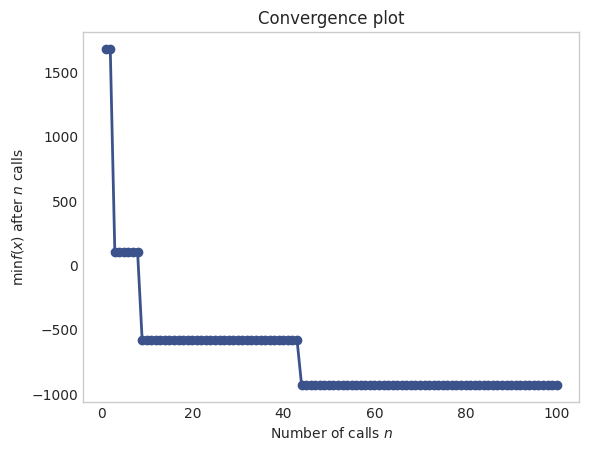

In [48]:
with plt.style.context(plt.style.available[26]):
    plot_convergence(res);

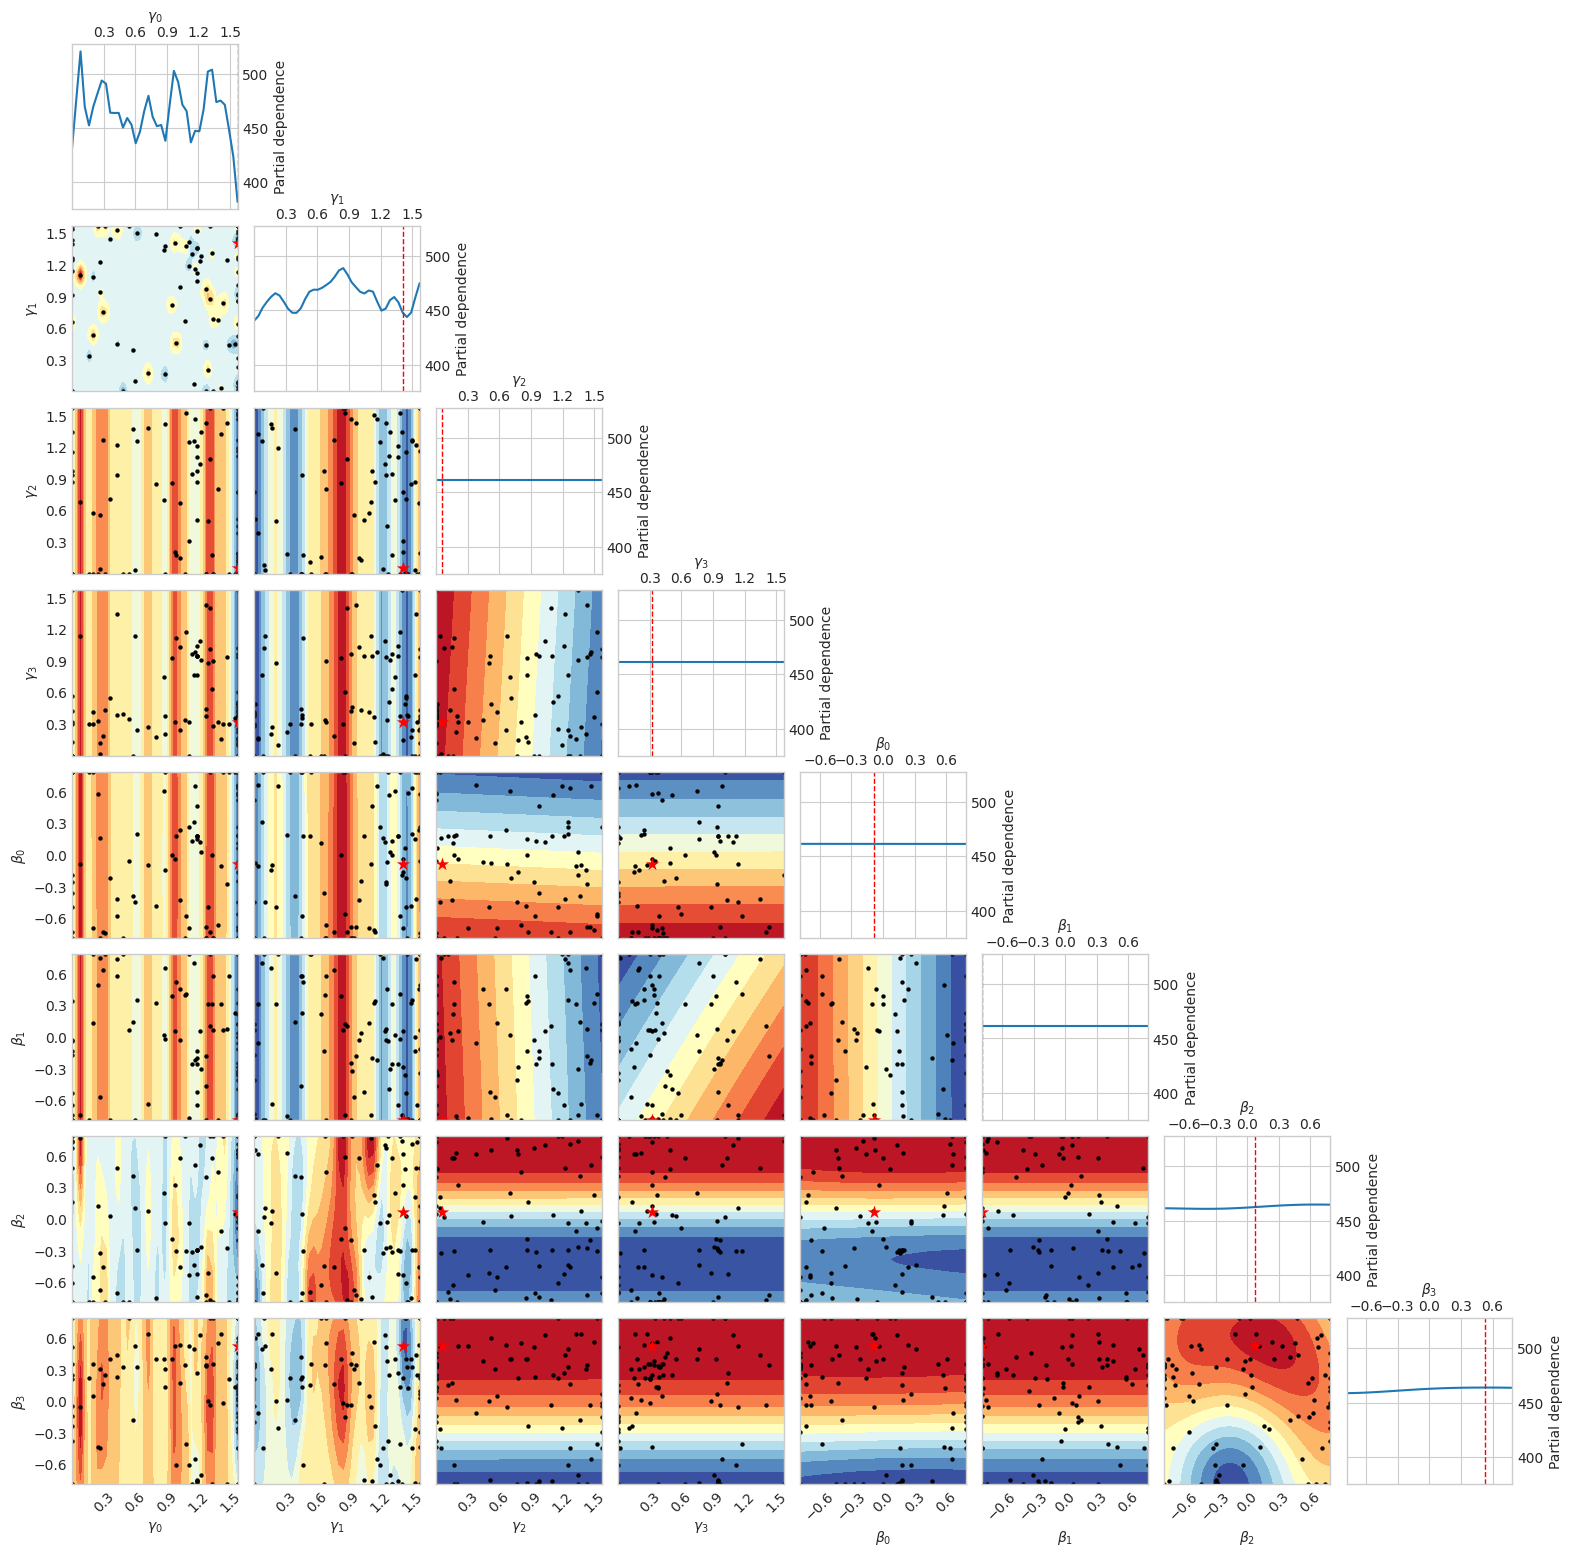

In [49]:
with plt.style.context(plt.style.available[26]):
    plot_objective(
        res, 
        cmap='RdYlBu_r',
        dimensions=[f'$\\gamma_{i}$' for i in range(p)] + [f'$\\beta_{i}$' for i in range(p)],
    );

In [50]:
print(res)

          fun: -930.2546247194581
            x: [1.5707953267948966, 1.4130868515956772, 0.05312861537295717, 0.3176039211450374, -0.08569181865570374, -0.7853971633974483, 0.06967343995218389, 0.5267697545028797]
    func_vals: [ 1.683e+03  2.968e+03 ...  4.653e+02  1.476e+03]
      x_iters: [[1.3103585246594323, 0.8801594534017564, 1.0907886155845208, 1.3975272590824415, -0.7332352636888942, 0.10179084285364792, -0.7708190336682692, -0.036086293898907384], [0.07410789517770615, 1.1069519002479844, 0.6760261032070105, 1.134306257807657, -0.09070517243117271, -0.7357894365183877, 0.7709531902972458, -0.052509222348750995], [0.2030441484154767, 1.0893397900438913, 0.573207089172746, 0.4184530106064258, -0.6904625692895541, 0.13553331360078869, -0.548295679669381, 0.04497888955034535], [0.4305834725867596, 1.5346844471854233, 1.2208767775869702, 1.3454387028320633, -0.4154004280123805, 0.7423548330537214, 0.4832444094043934, 0.43892736206215976], [0.8724140873220985, 1.3391547243836588,

In [52]:
%%time
from collections import Counter

# sample it 100 times, count results:
Counter(circ_ex.sample(1000))


CPU times: total: 1min 32s
Wall time: 1min 40s


Counter({'100100010': 3,
         '011011100': 2,
         '111101111': 7,
         '101000111': 2,
         '111010010': 9,
         '001111010': 2,
         '010100000': 3,
         '100100000': 13,
         '101100111': 1,
         '001001111': 11,
         '110111001': 12,
         '100100111': 10,
         '101111101': 2,
         '001110110': 1,
         '100111001': 8,
         '001010100': 1,
         '011111100': 10,
         '111011011': 12,
         '101100011': 3,
         '100110100': 3,
         '101111010': 7,
         '111110110': 14,
         '000110111': 3,
         '000010111': 4,
         '000101100': 3,
         '011000011': 4,
         '000100100': 7,
         '110111010': 7,
         '000100000': 3,
         '010000000': 5,
         '100101111': 5,
         '010000010': 4,
         '000000001': 6,
         '010001001': 1,
         '110010010': 6,
         '110000111': 5,
         '111011010': 3,
         '111000000': 7,
         '011110010': 1,
         '11110100

In [58]:
counter  ={'100100010': 3,
         '011011100': 2,
         '111101111': 7,
         '101000111': 2,
         '111010010': 9,
         '001111010': 2,
         '010100000': 3,
         '100100000': 13,
         '101100111': 1,
         '001001111': 11,
         '110111001': 12,
         '100100111': 10,
         '101111101': 2,
         '001110110': 1,
         '100111001': 8,
         '001010100': 1,
         '011111100': 10,
         '111011011': 12,
         '101100011': 3,
         '100110100': 3,
         '101111010': 7,
         '111110110': 14,
         '000110111': 3,
         '000010111': 4,
         '000101100': 3,
         '011000011': 4,
         '000100100': 7,
         '110111010': 7,
         '000100000': 3,
         '010000000': 5,
         '100101111': 5,
         '010000010': 4,
         '000000001': 6,
         '010001001': 1,
         '110010010': 6,
         '110000111': 5,
         '111011010': 3,
         '111000000': 7,
         '011110010': 1,
         '111101000': 3,
         '001101100': 2,
         '111100100': 9,
         '011011101': 1,
         '011000000': 4,
         '001101111': 3,
         '110100001': 1,
         '100101001': 6,
         '111000111': 22,
         '011111111': 4,
         '101001100': 1,
         '101001111': 1,
         '101010011': 2,
         '010100111': 1,
         '110110000': 8,
         '101000011': 2,
         '100011000': 4,
         '010010010': 1,
         '010001000': 1,
         '010010000': 10,
         '101101000': 6,
         '110111011': 3,
         '110100101': 3,
         '010110010': 4,
         '110111111': 5,
         '110100100': 3,
         '011111011': 3,
         '111110011': 2,
         '010011010': 4,
         '111111111': 11,
         '011001100': 4,
         '011010011': 1,
         '100101011': 2,
         '011011000': 7,
         '010011000': 1,
         '001011110': 1,
         '000010100': 2,
         '111100000': 4,
         '111011100': 4,
         '010010001': 3,
         '010101111': 2,
         '111110001': 3,
         '110000011': 1,
         '101011011': 4,
         '000000111': 7,
         '111011111': 7,
         '010010100': 1,
         '010000001': 2,
         '100100110': 2,
         '010101110': 4,
         '110101101': 4,
         '000010101': 3,
         '101110100': 2,
         '101001110': 3,
         '010011001': 2,
         '110001110': 4,
         '000011011': 3,
         '111001001': 13,
         '000111000': 15,
         '011000001': 1,
         '111101101': 9,
         '100111010': 9,
         '000101101': 2,
         '101001011': 2,
         '011111001': 4,
         '101011001': 1,
         '101100010': 1,
         '001101001': 1,
         '111111001': 2,
         '000001110': 3,
         '000000000': 12,
         '010010111': 5,
         '111010110': 1,
         '100101000': 1,
         '101010010': 3,
         '101101010': 1,
         '001001110': 3,
         '100000111': 3,
         '010101001': 2,
         '111011101': 9,
         '000010010': 7,
         '001000100': 2,
         '110011100': 1,
         '001010110': 2,
         '011101101': 4,
         '001000010': 3,
         '010101101': 6,
         '001000000': 6,
         '111010101': 3,
         '111100110': 1,
         '100011001': 2,
         '110100011': 3,
         '001100111': 1,
         '101000101': 1,
         '110111100': 5,
         '001000001': 3,
         '110011111': 5,
         '001111100': 2,
         '111001110': 6,
         '001001000': 10,
         '001100000': 3,
         '001010101': 2,
         '010000101': 5,
         '001000111': 7,
         '110000000': 3,
         '011110110': 2,
         '100010101': 2,
         '000001001': 8,
         '010110100': 3,
         '001011001': 2,
         '011110111': 4,
         '001011111': 2,
         '001101000': 3,
         '111001000': 3,
         '110010101': 2,
         '110101111': 5,
         '011101011': 1,
         '100100011': 4,
         '001010000': 2,
         '100000000': 5,
         '110000110': 1,
         '110100111': 1,
         '000110001': 2,
         '001110101': 1,
         '000101111': 3,
         '001011010': 4,
         '101000100': 1,
         '011000100': 1,
         '111111000': 11,
         '110110110': 3,
         '011100111': 1,
         '100011110': 3,
         '000010000': 9,
         '000111100': 3,
         '010100011': 3,
         '111011000': 1,
         '000011010': 3,
         '100001110': 2,
         '101010110': 1,
         '010101000': 2,
         '011111010': 3,
         '000000010': 1,
         '011001110': 4,
         '101100001': 1,
         '100110010': 4,
         '000101001': 2,
         '000001111': 1,
         '010010101': 5,
         '000001100': 4,
         '001100100': 1,
         '001100110': 2,
         '110110010': 1,
         '000101110': 2,
         '001000011': 3,
         '010111100': 6,
         '001011100': 1,
         '011111101': 2,
         '000000100': 1,
         '000011001': 4,
         '111100111': 2,
         '111100011': 6,
         '100010111': 2,
         '000010011': 2,
         '101001010': 2,
         '100010000': 2,
         '100011011': 3,
         '001001010': 2,
         '101111001': 3,
         '111101010': 3,
         '110011010': 1,
         '101000000': 2,
         '100110111': 4,
         '110000001': 2,
         '110011011': 4,
         '000111001': 2,
         '100010100': 1,
         '110111101': 2,
         '010111101': 3,
         '001010011': 1,
         '000110010': 4,
         '010111001': 2,
         '101000110': 2,
         '000011111': 5,
         '001000110': 1,
         '111101110': 2,
         '001111110': 3,
         '010011101': 1,
         '001010001': 1,
         '101100100': 1,
         '100111111': 4,
         '011000110': 2,
         '000100010': 1,
         '011000111': 2,
         '101101101': 2,
         '010000100': 1,
         '100101010': 2,
         '001001101': 1,
         '100000101': 1,
         '100100100': 2,
         '110101110': 2,
         '011011011': 2,
         '110010001': 1,
         '101110111': 3,
         '010101010': 1,
         '001110000': 1,
         '010001110': 1,
         '010001010': 1,
         '011100101': 1,
         '100010011': 1,
         '011010110': 4,
         '000111101': 2,
         '110010011': 2,
         '001000101': 2,
         '110001101': 1,
         '011011010': 1,
         '011101111': 5,
         '111001101': 1,
         '000100111': 4,
         '100000100': 3,
         '000010001': 1,
         '010101011': 1,
         '000110110': 4,
         '011111110': 2,
         '100011010': 3,
         '010000111': 5,
         '101111100': 1,
         '100001100': 1,
         '110110011': 1,
         '100000010': 3,
         '110000100': 1,
         '110111110': 1,
         '010100010': 1,
         '101011111': 1,
         '100001011': 2,
         '111110111': 6,
         '110000010': 1,
         '000100001': 2,
         '111100010': 1,
         '010100101': 1,
         '011010101': 1,
         '001111000': 1,
         '010000011': 1,
         '100011101': 1,
         '010110111': 2,
         '011001111': 1,
         '100110011': 1,
         '100111011': 2,
         '000110100': 1,
         '001110100': 1,
         '100110001': 1,
         '111101011': 1,
         '001100011': 1,
         '001010111': 1,
         '000110101': 1,
         '100110000': 1,
         '000010110': 1,
         '010101100': 2,
         '000001000': 1,
         '111111010': 1,
         '001110010': 1,
         '010111111': 3,
         '000100011': 2,
         '010110101': 1,
         '001101110': 1,
         '110000101': 1,
         '011000101': 1,
         '101110110': 2,
         '000111010': 1,
         '100001000': 1,
         '010001011': 1,
         '000001101': 1,
         '000001010': 2,
         '100100101': 1,
         '000011110': 1,
         '001111111': 1,
         '111001111': 1,
         '010011111': 3,
         '001100001': 1,
         '111000101': 1,
         '111100001': 1,
         '100001101': 1,
         '101100110': 1,
         '101010101': 1,
         '001111011': 1,
         '110110001': 2,
         '011100011': 1,
         '111111100': 1,
         '111001010': 1,
         '001111101': 1,
         '010001111': 1}

In [64]:
TSP =  {'001110000': 1,
         '010001110': 1,
         '010001010': 1,
         '011100101': 1,
         '100010001': 512,
         '011010110': 4,
         '000111101': 2}


In [62]:
import itertools



l =dict(itertools.islice(counter.items(), 2))
l


{'100100010': 3, '011011100': 2}

<BarContainer object of 7 artists>

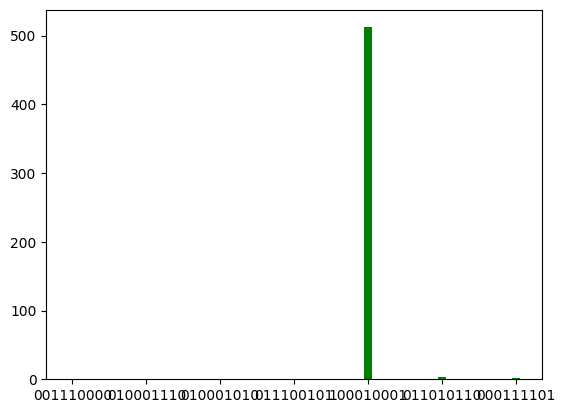

In [75]:
# plot a histogram of the results

plt.bar(TSP.keys(), TSP.values(), width=0.1, color='g')

In [ ]:
plt.hist(TSP.values(), bins=10, range=(0, 10), facecolor='g', alpha=0.75)

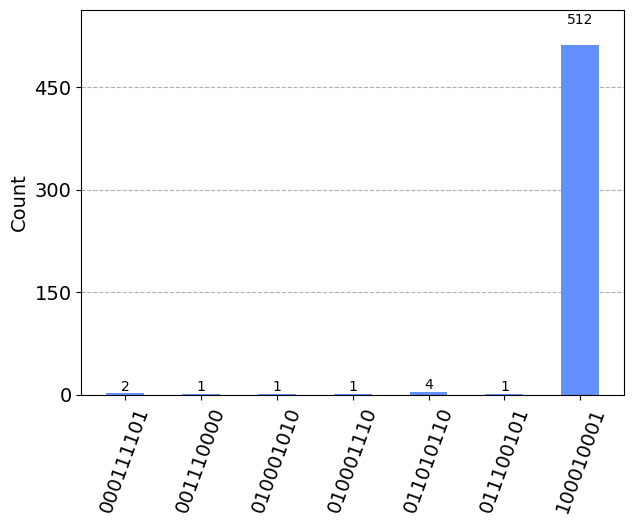

In [77]:
from qiskit.visualization import plot_histogram
plot_histogram(TSP)

In [61]:
# how to slice a dictionary
# https://stackoverflow.com/questions/1663807/how-to-iterate-through-a-dictionary-in-python
d = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}
for key in d:
    print(key, d[key])  


a 1
b 2
c 3
d 4
e 5
